# Text classification problem

In [ ]:
import pandas as pd
import numpy as np
import statistics
import math
import re
import os

import string
import spacy
from spacy.lang.en import English

import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

# Data Analysis and Preprocess

First we have defined some functions to read the dataset and plot them for some basic analysis

In [ ]:
def parse_files(path):
  '''
  Parse text files in the given directory and return a DataFrame containing the text content and corresponding category for each file.
  '''
  folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
  dataframes_list = []

  for category in folders:
    category_path = os.path.join(path, category)
    for filename in sorted(os.listdir(category_path)):
      if filename.endswith('.txt'):
        with open(os.path.join(category_path, filename), 'r', encoding='unicode_escape') as f:
          content = f.read()
          dataframes_list.append(pd.DataFrame({'text':content, 'category':category}, index=[0]))
  df = pd.concat(dataframes_list, ignore_index=True)

  return df

In [ ]:
def plot_file_counts(df, category_col):
    '''
    This function takes a dataframe and the name of the column containing
    category labels as input. It counts the number of text files per category
    and plots them as a horizontal bar chart.
    '''
    # Count the number of the text files per category
    file_counts = df[category_col].value_counts()

    # Create a horizontal bar chart
    fig, ax = plt.subplots(figsize=(8,6))
    ax.barh(file_counts.index, file_counts.values, alpha=0.8)
    ax.set_xlabel('Number of Text Files')
    ax.set_ylabel('Category')
    ax.set_title('Number of Text Files per Category')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_wordclouds(df, text_col, category_col):
    '''
    This function takes a DataFrame, a text column name, and a category column name as input.
    It generates a word cloud visualization for each category in the DataFrame and displays them in a grid of subplots.
    '''

    # Group the text data by category
    grouped = df.groupby(category_col)

    # Create a grid of subplots
    n_categories = len(grouped)
    n_cols = min(n_categories, 3)
    n_rows = int(n_categories / n_cols) + (n_categories % n_cols > 0)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))

    # Generate a word cloud for each category
    for (category, group), ax in zip(grouped, axes.flatten()):
        # Concatenate all text data into a single string
        text = ' '.join(group[text_col].tolist())

        # Create and generate a word cloud image
        wordcloud = WordCloud(width=400, height=400, background_color='white', max_words=100, colormap='Blues').generate(text)

        # Display the generated image
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(category)
        ax.axis('off')

    # Remove any empty subplots
    for i in range(n_categories, n_rows * n_cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

In [ ]:
path = 'Text_dataset/raw'
df = parse_files(path)
df.head()

,text,category
0,Labour plans maternity pay rise\n\nMaternity p...,politics
1,Watchdog probes e-mail deletions\n\nThe inform...,politics
2,Hewitt decries 'career sexism'\n\nPlans to ext...,politics
3,Labour chooses Manchester\n\nThe Labour Party ...,politics
4,Brown ally rejects Budget spree\n\nChancellor ...,politics


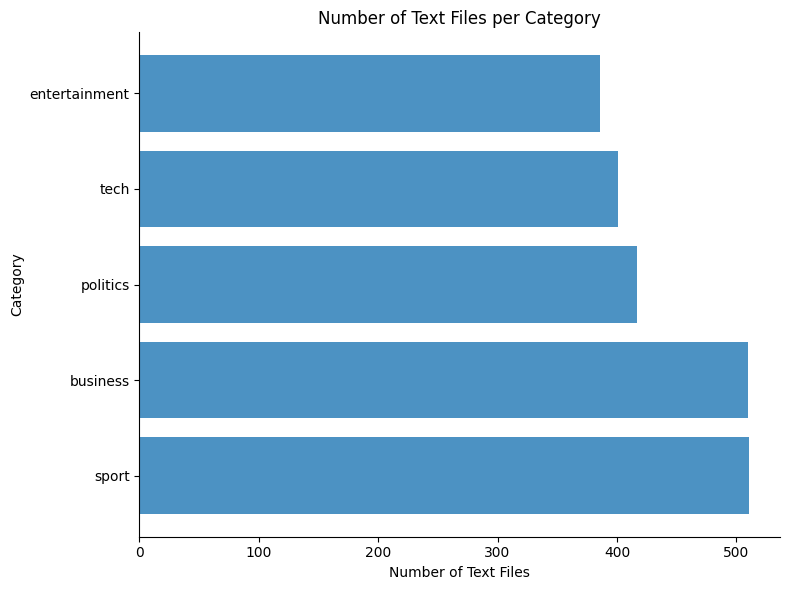

In [ ]:
plot_file_counts(df, 'category')

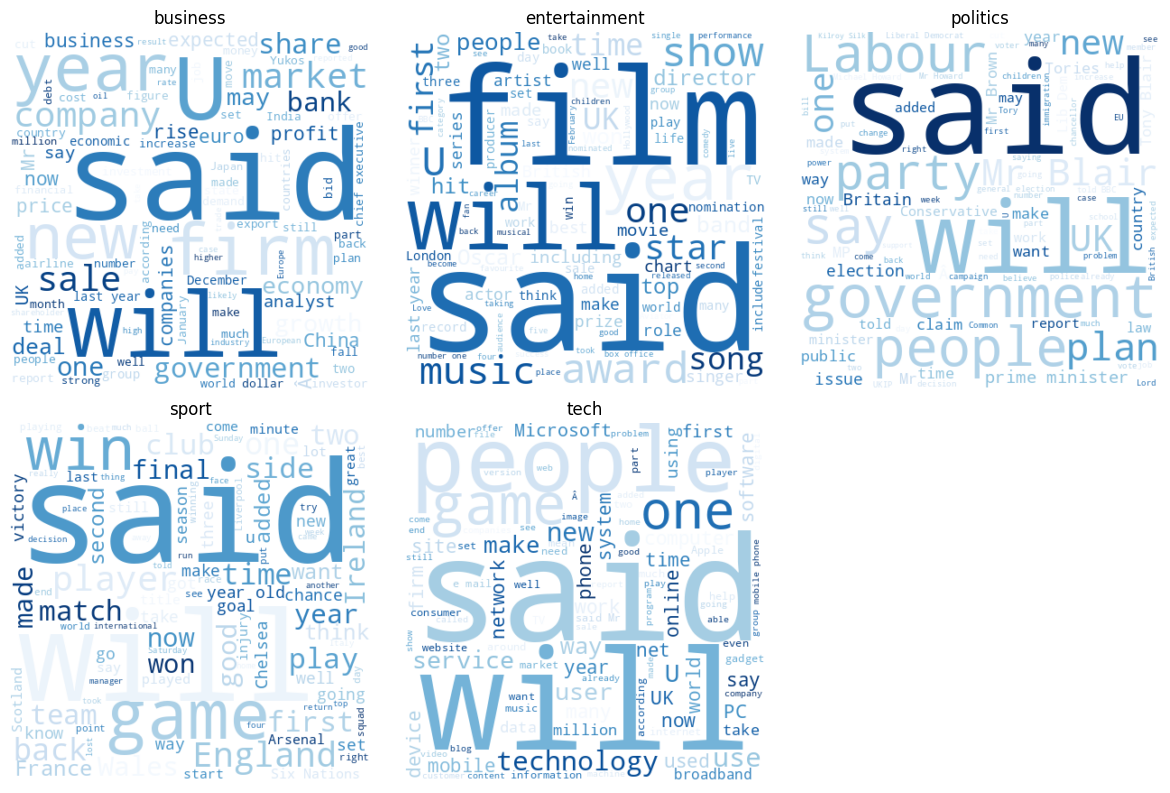

In [ ]:
plot_wordclouds(df, 'text', 'category')

In [ ]:
# Calculate statistics related to text length for each category in a DataFrame
def calculate_text_length_stats(df, split_char=' '):
    '''
    This function takes a DataFrame and an optional split character as input.
    It calculates various statistics related to the number of words per text file for each category in the DataFrame.
    The function returns two objects: a dictionary of global statistics and a DataFrame of statistics per category.
    '''

    # Get unique categories in the DataFrame
    categories = df['category'].unique()

    # Initialize variables to store statistics
    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Get the text and category for the current row
        text = row['text']
        category = row['category']

        # Normalize the text by removing extra whitespace
        text = re.sub(r"\s+", ' ', text)

        # Split the text into individual words
        text = text.split(split_char)

        # Get the length of the text (i.e., the number of words)
        l = len(text)

        # Update the statistics for the current category
        all_lengths.append(l)
        per_category['lengths'][category].append(l)

    # Calculate the mean and standard deviation for each category
    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])

    # Calculate the overall mean and standard deviation for all text files
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }

    # Return the statistics as a dictionary of global statistics and a DataFrame of per-category statistics
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }

In [ ]:
# Plot histograms of text length distributions for each category
def plot_text_length_histograms(df_stats, n_cols=3):
    '''
    This function takes a dictionary of global and per-category statistics as input,
    along with an optional number of columns for the grid of subplots.
    It generates a histogram of text length distributions for each category in the dataset,
    and displays them in a grid of subplots.
    '''

    # Get the unique categories in the DataFrame
    categories = df['category'].unique()

    # Calculate the number of rows needed for the grid of subplots
    n_rows = math.ceil(len(categories) / n_cols)

    # Create a figure with subplots for each category
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of Text Lengths')

    # Plot the overall distribution of text lengths in the first subplot
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All Categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Plot the distribution of text lengths for each category in a separate subplot
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)

        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    # Display the plot
    plt.show()

**In these histograms and stats, we can see that almost all texts contain $1000$ or less words. Also, we can see that the average length is very different depending on the category.**

In [ ]:
# Calculate text length statistics
stats = calculate_text_length_stats(df)
stats['per_category']

,lengths,mean,stdev
politics,"[451, 380, 524, 253, 505, 348, 515, 537, 531, ...",454.973621,300.120275
tech,"[673, 384, 213, 465, 805, 630, 279, 285, 1235,...",503.695761,239.849176
sport,"[212, 145, 378, 196, 162, 147, 126, 236, 388, ...",330.262231,187.963267
business,"[422, 385, 265, 407, 266, 185, 285, 322, 230, ...",329.880392,135.919077
entertainment,"[191, 254, 193, 215, 180, 229, 360, 303, 336, ...",331.621762,261.795254


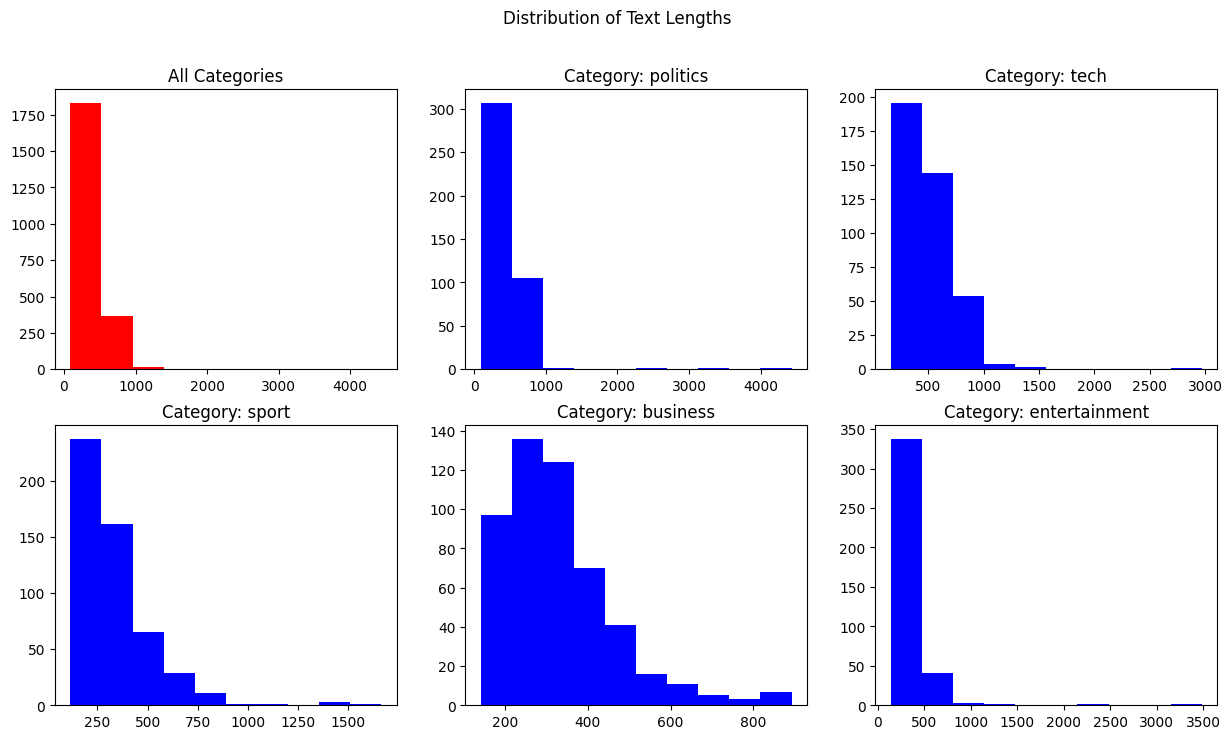

In [ ]:
# Plot histograms of text length distributions
plot_text_length_histograms(stats)

**Preprocess: clean characters**

Before we start to apply other techniques to clean the texts, we have removed every character which cannot be used to write words in English (this set of characters is different in other languages). Using the following function, we have removed all puntuation symbols from all texts as well as we have normalized the white spaces.

In [ ]:
def clean_punctuation(df):
    """
    Clean punctuation and normalize whitespace in the 'text' column of a DataFrame.
    Replaces all punctuation characters with spaces, and normalizes whitespace characters to a single space.

    Args:
        df: A pandas DataFrame with a 'text' column to be cleaned.

    Returns:
        The cleaned pandas DataFrame.
    """
    for index, row in df.iterrows():
        # Get the text from the current row
        text = row['text']

        # Replace punctuation characters with spaces
        text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))

        # Normalize whitespace to a single space
        text = ' '.join(text.split())

        # Update the 'text' column with the cleaned text
        row['text'] = text

    return df

In [ ]:
df = clean_punctuation(df)
df.head()

,text,category
0,Labour plans maternity pay rise Maternity pay ...,politics
1,Watchdog probes e mail deletions The informati...,politics
2,Hewitt decries career sexism Plans to extend p...,politics
3,Labour chooses Manchester The Labour Party wil...,politics
4,Brown ally rejects Budget spree Chancellor Gor...,politics


In [ ]:
# Calculate text length statistics
stats = calculate_text_length_stats(df)
stats['per_category']

,lengths,mean,stdev
politics,"[459, 393, 531, 254, 515, 350, 527, 543, 555, ...",461.501199,305.215664
tech,"[675, 388, 225, 470, 819, 649, 279, 300, 1250,...",513.251870,243.084510
sport,"[221, 156, 396, 196, 184, 153, 133, 238, 415, ...",341.142857,193.835379
business,"[441, 398, 271, 423, 278, 190, 291, 329, 237, ...",338.313725,138.049561
entertainment,"[193, 261, 198, 229, 189, 236, 367, 302, 339, ...",339.945596,267.569347


The average length is greater now but, why? Since we have _normalized_ the characters in the texts, there are many more white spaces now, hence apparently there are more words. For example, if we had in the original text "*U2's desire*", now we have "*U2 s desire*" (i.e. one more word has appeared due to we have tokenized using the white spaces).



```
# This is formatted as code
```

**Preprocess: Lematization**

In this notebook, we are going to do **lematization** over all the texts. To do so, we will use the library **Spacy** since it already has detailed dictionaries which the algorithm can look through to link the form back to its lemma.

We can illustrate the method with an example:

| Word | Lemma |
|---|---|
| studying | study |
| studies | study |

This process may look similar to *stemming* (which we are not going to use), but it leads to a different result.

In [ ]:
def lemmatize_dataset(df, join_char=' '):
    """
    Lemmatize the 'text' column of a pandas DataFrame using the Spacy library.

    Args:
        df: A pandas DataFrame with a 'text' column to be lemmatized.
        join_char: The character to use when joining the lemmatized tokens into a string. Default is ' '.

    Returns:
        The lemmatized pandas DataFrame.
    """
    # Load the Spacy English model
    nlp = spacy.load('en_core_web_sm')

    for index, row in df.iterrows():
        # Get the text from the current row
        text = row['text']

        # Tokenize the text and lemmatize each token
        tokens = nlp(text)
        lemmatized_tokens = [w.lemma_.strip().lower() if w.lemma_ != "-PRON-" else w.lower_ for w in tokens]

        # Join the lemmatized tokens into a string
        lemmatized_text = join_char.join(lemmatized_tokens)

        # Update the 'text' column with the lemmatized text
        row['text'] = lemmatized_text

    return df

In [ ]:
df = lemmatize_dataset(df)
df.head()

,text,category
0,labour plan maternity pay rise maternity pay f...,politics
1,watchdog probe e mail deletion the information...,politics
2,hewitt decry career sexism plan to extend pay ...,politics
3,labour choose manchester the labour party will...,politics
4,brown ally reject budget spree chancellor gord...,politics


In [ ]:
# Calculate text length statistics
stats = calculate_text_length_stats(df)
stats['per_category']

,lengths,mean,stdev
politics,"[459, 393, 532, 254, 515, 352, 527, 543, 555, ...",461.954436,305.506516
tech,"[675, 388, 225, 470, 819, 649, 279, 300, 1250,...",513.947631,243.423797
sport,"[223, 156, 399, 196, 190, 157, 138, 238, 425, ...",342.033268,194.650136
business,"[446, 398, 274, 430, 278, 190, 291, 329, 237, ...",339.345098,138.068911
entertainment,"[193, 261, 199, 229, 190, 236, 368, 302, 339, ...",340.997409,267.566780


**Preprocess: Stop words**

Stop words are a set of commonly used words in any language. For example, in English, "the", "is" and "or", would easily qualify as stop words. These words are not semantically useful in the sentences, thus it is a good idea to remove them and focus on important words instead.

In [ ]:
def clean_stop_words(df, join_char=' ', split_char=' '):
    """
    Iterate over rows in the DataFrame and tokenize the texts by splitting them with split_char.
    Check if tokens in the resulting list are not stop words.
    Convert the list back to a string using join_char as the separator.

    Args:
        df: The pandas DataFrame to clean stop words from.
        join_char: The character to use when joining the cleaned tokens into a string. Default is ' '.
        split_char: The character to use when splitting the texts into tokens. Default is ' '.

    Returns:
        The DataFrame with stop words removed from the 'text' column.
    """
    # Get the list of stop words
    stop_words = list(spacy.lang.en.stop_words.STOP_WORDS) + list(string.punctuation)

    # Load the Spacy English model
    nlp = spacy.load('en_core_web_sm')

    # Initialize a list to store the cleaned texts
    cleaned_texts = []

    # Iterate over rows in the DataFrame
    for index, row in df.iterrows():
        # Get the text from the current row
        text = row['text']

        # Tokenize the text by splitting it with split_char
        tokens = text.split(split_char)

        # Filter out stop words
        cleaned_tokens = [token for token in tokens if token.lower() not in stop_words]

        # Join the cleaned tokens into a string
        cleaned_text = join_char.join(cleaned_tokens)

        # Add the cleaned text to the list
        cleaned_texts.append(cleaned_text)

    # Update the 'text' column with the cleaned texts
    df['text'] = cleaned_texts

    # Return the DataFrame with stop words removed
    return df


In [ ]:
df = clean_stop_words(df)
df.head()

,text,category
0,labour plan maternity pay rise maternity pay n...,politics
1,watchdog probe e mail deletion information com...,politics
2,hewitt decry career sexism plan extend pay mat...,politics
3,labour choose manchester labour party hold 200...,politics
4,brown ally reject budget spree chancellor gord...,politics


In [ ]:
# Calculate text length statistics
stats = calculate_text_length_stats(df)
stats['per_category']

,lengths,mean,stdev
politics,"[223, 212, 268, 124, 261, 163, 272, 262, 310, ...",232.105516,138.141505
tech,"[343, 207, 125, 204, 414, 335, 148, 170, 614, ...",261.935162,111.661053
sport,"[119, 90, 189, 93, 121, 90, 89, 99, 250, 153, ...",174.293542,101.753161
business,"[254, 213, 155, 261, 166, 107, 153, 179, 150, ...",188.360784,71.556504
entertainment,"[105, 160, 116, 132, 119, 144, 210, 172, 181, ...",183.932642,127.966272


Now we can see that, after we have removed the stop words, the average lengths have decreased significantly.

**Preprocess: TF-IDF**

The TF-IDF value is calculated by multiplying the term frequency by the inverse document frequency.

In the following code, we have removed the words based on the TF-IDF value. That is, we have removed from the dataset those words whose TF-IDF value is less than a certain threshold.
We can use the implemented TF-IDF function provided in the scikit-learn
but in this notebook we implemented from scratch to see the details
you can compare the results with below function:

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [ ]:
def calculate_term_frequency(df, split_char=' '):
    """
    Calculates the term frequency for each document in the given dataframe.

    :param df: A pandas dataframe containing the text documents.
    :param split_char: The character used to split the text into tokens.
    :return: A list of dictionaries, where each dictionary represents the term frequency for one document.
    """
    term_frequency = []
    for index, row in df.iterrows():
        tokens = row['text'].split(split_char)

        # Calculate the absolute frequency of each word/token in the document.
        words_freqs = {}
        for w in tokens:
            words_freqs[w] = 1 if w not in words_freqs else (words_freqs[w] + 1)

        # Normalize the absolute frequency by dividing each value by the maximum value.
        max_freq = max(list(words_freqs.values()))
        words_freqs = {w: (abs_freq / max_freq) for w, abs_freq in words_freqs.items()}

        term_frequency.append(words_freqs)

    return term_frequency


def calculate_inverse_document_frequency(df, split_char=' '):
    """
    Calculates the inverse document frequency for each term in the given dataframe.

    :param df: A pandas dataframe containing the text documents.
    :param split_char: The character used to split the text into tokens.
    :return: A dictionary where the keys are the terms and the values are the corresponding IDF values.
    """
    inverse_document_frequency = {}
    num_documents = len(df.index)

    # Count the number of documents that contain each term.
    count_usage = {}
    for index, row in df.iterrows():
        tokens = row['text'].split(split_char)

        vocabulary_in_doc = list(set(tokens))
        for w in vocabulary_in_doc:
            if w not in count_usage:
                count_usage[w] = 1
            else:
                count_usage[w] += 1

    # Calculate the IDF value for each term.
    for w, count in count_usage.items():
        inverse_document_frequency[w] = math.log(num_documents / count)

    return inverse_document_frequency


def calculate_tf_idf(df, split_char=' '):
    """
    Calculates the TF-IDF value for each term in each document in the given dataframe.

    :param df: A pandas dataframe containing the text documents.
    :param split_char: The character used to split the text into tokens.
    :return: A list of dictionaries, where each dictionary represents the TF-IDF values for one document.
    """
    term_frequency = calculate_term_frequency(df, split_char)
    inverse_document_frequency = calculate_inverse_document_frequency(df, split_char)

    tf_idf = []
    for index, row in df.iterrows():
        tokens = row['text'].split(split_char)
        vocabulary_in_doc = list(set(tokens))

        # Calculate the TF-IDF value for each term in the document.
        row_tf_idf = {}
        for w in vocabulary_in_doc:
            row_tf_idf[w] = term_frequency[index][w] * inverse_document_frequency[w]

        tf_idf.append(row_tf_idf)

    return tf_idf


def apply_tf_idf_threshold(df, split_char=' ', join_char=' '):
    """
    Applies a threshold to the TF-IDF values for each term in each document in the given dataframe.

    :param df: A pandas dataframe containing the text documents.
    :param split_char: The character used to split the text into tokens.
    :param join_char: The character used to join the tokens back into text.
    :return: The input dataframe with the text in each document modified based on the TF-IDF threshold.
    """
    tf_idf_values = calculate_tf_idf(df, split_char)

    for doc_i, doc_tf_idf in enumerate(tf_idf_values):
        # Sort the terms in the document by their TF-IDF value in descending order.
        doc_tf_idf = {k: v for k, v in sorted(doc_tf_idf.items(), key=lambda item: item[1], reverse=True)}

        # Calculate the probability distribution of the TF-IDF values.
        doc_tf_idf_values = np.array(list(doc_tf_idf.values()))
        probs = doc_tf_idf_values / sum(doc_tf_idf_values)

        # Find the threshold value for the TF-IDF values.
        p_value = 0
        for i, p in enumerate(probs):
            if p_value < 0.975:
                p_value += p
            else:
                break
        threshold = doc_tf_idf_values[i]

        # Remove the terms with TF-IDF values below the threshold.
        row = df.loc[doc_i, :]
        tokens = row['text'].split(split_char)
        i = len(tokens)

        original_tokens = tokens.copy()
        while i >= 0:
            i -= 1

            w = tokens[i]
            if doc_tf_idf[w] < threshold:
                del tokens[i]

        # Sort the terms in the document by their TF-IDF value in ascending order.
        doc_tf_idf = {k: v for k, v in sorted(doc_tf_idf.items(), key=lambda item: item[1])}

        # Join the remaining terms back into text and update the corresponding row in the dataframe.
        row['text'] = join_char.join(tokens)

    return df

In [ ]:
apply_tf_idf_threshold(df)
df.head()

,text,category
0,labour plan maternity pay rise maternity pay n...,politics
1,watchdog probe e mail deletion information com...,politics
2,hewitt decry career sexism plan extend pay mat...,politics
3,labour choose manchester labour party hold 200...,politics
4,brown ally reject budget spree chancellor gord...,politics


In [ ]:
# Calculate text length statistics
stats = calculate_text_length_stats(df)
stats['per_category']

,lengths,mean,stdev
politics,"[209, 200, 252, 115, 244, 153, 252, 244, 286, ...",216.376499,129.999037
tech,"[321, 196, 117, 190, 384, 311, 139, 160, 566, ...",245.032419,104.894597
sport,"[112, 82, 174, 87, 107, 83, 83, 93, 225, 143, ...",160.880626,94.410552
business,"[238, 193, 147, 242, 150, 99, 142, 164, 139, 1...",174.494118,66.253954
entertainment,"[95, 144, 104, 113, 106, 131, 191, 162, 167, 1...",169.284974,120.295315


After **preprocessing** stage we can see a better wordcloud visualization with more related words in each category.

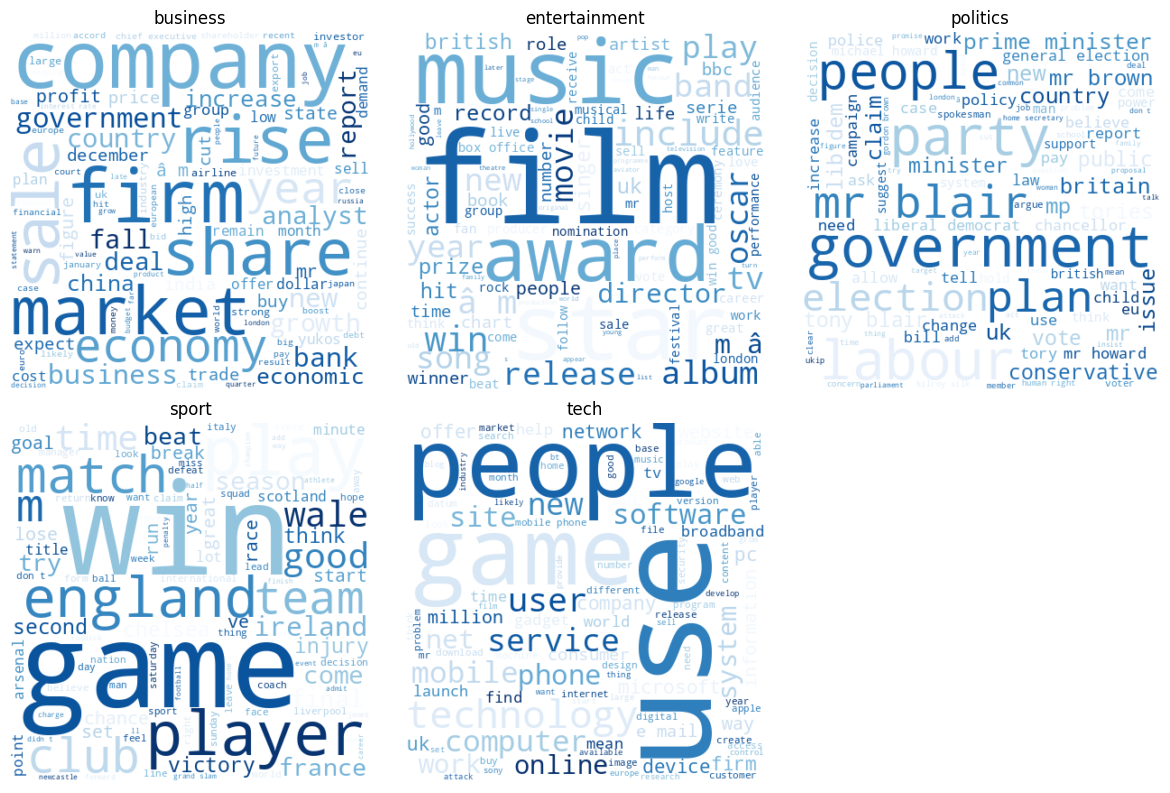

In [ ]:
plot_wordclouds(df, 'text', 'category')

## Store parsed dataset

Finally, we have stored the dataset as a CSV file, so we could use it to train different models :)

In [ ]:
## provide a path
path = 'Text_dataset/parsed_dataset.csv'
df.to_csv(path, index_label=False)

## Train and Test Split and some data preperation to inject to the models

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# a function for getting all categeries
def get_categories(df):
    return df['category'].unique()

In [ ]:
# provide the file path
path = 'Text_dataset/parsed_dataset.csv'
df = pd.read_csv(path)
df.head()

,text,category
0,labour plan maternity pay rise maternity pay n...,politics
1,watchdog probe e mail deletion information com...,politics
2,hewitt decry career sexism plan extend pay mat...,politics
3,labour choose manchester labour party hold 200...,politics
4,brown ally reject budget spree chancellor gord...,politics


In [ ]:
# Convert the 'text' and 'category' columns of the our dataFrame to numpy arrays, text is as "X" and category is as "Y" or target
# Flatten the resulting 2D arrays to 1D arrays for easy use in machine learning algorithms
X_data = df[['text']].to_numpy().reshape(-1)
Y_data = df[['category']].to_numpy().reshape(-1)

In [ ]:
# Printing some information about our data and then splitting it to Train to Test
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

n_categories = len(get_categories(df))
print('Number of categories: %d' % n_categories)


print('Loading Train Dataset...')

# split the data with a suitable ratio
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=74)
print('Done!')

Texts in dataset: 2225
Number of categories: 5
Loading Train Dataset...
Done!


## Create model

Here we used `GridSearch` and cross-validation to find the best parameters.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

### SGDClassifier Model with tuning the hyperparameters

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
# Define the hyperparameters to tune
parameters = {
    'clf__loss': ['hinge', 'log_loss', 'modified_huber'],
    'clf__penalty': ['l1', 'l2'],
    'clf__alpha': [0.0001, 0.001, 0.01, 0.1]
}

# Define the pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(strip_accents=None, lowercase=False)),
    ('clf', SGDClassifier())
])

# Perform grid search with 10-fold cross validation
clf = GridSearchCV(pipeline, parameters, cv=10, n_jobs=-1)

# Fit the data
clf.fit(X_train, Y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(lowercase=False)),
                                       ('clf', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.0001, 0.001, 0.01, 0.1],
                         'clf__loss': ['hinge', 'log_loss', 'modified_huber'],
                         'clf__penalty': ['l1', 'l2']})

In [ ]:
print('Best parameters set of SGDClassifier:')
print(clf.best_params_)

Best parameters set of SGDClassifier:
{'clf__alpha': 0.1, 'clf__loss': 'hinge', 'clf__penalty': 'l2'}


### Random Forest Model with tuning the hyperparameters

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', RandomForestClassifier())
])

# Define the hyperparameters to tune
parameters = {
    'vect__stop_words': ['english', None],
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__min_df': [1, 2, 3],
    'clf__n_estimators': [10, 50, 100],
    'clf__max_depth': [None, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

# Perform grid search with 10-fold cross validation
clf = GridSearchCV(pipeline, parameters, cv=10, n_jobs=-1)

# Fit the data
clf.fit(X_train, Y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 5, 10],
                         'clf__min_samples_leaf': [1, 2, 4],
                         'clf__n_estimators': [10, 50, 100],
                         'vect__max_df': [0.5, 0.75, 1.0],
                         'vect__min_df': [1, 2, 3],
                         'vect__stop_words': ['english', None]})

### SVM and Logistic Regression Models with tuning the hyperparameters

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
# Define the hyperparameters to tune for each model
parameters_svm = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'clf__kernel': ['linear', 'rbf'],
    'clf__C': [0.01, 0.1, 1],
    'clf__gamma': [0.01, 0.1, 1]
}
parameters_logistic = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'clf__penalty': ['l2'],
    'clf__C': [0.01, 0.1, 1, 10]
}

# Define the pipeline for each model
pipeline_svm = Pipeline([
    ('vect', CountVectorizer(strip_accents=None, lowercase=False)),
    ('clf', SVC())
])
pipeline_logistic = Pipeline([
    ('vect', CountVectorizer(strip_accents=None, lowercase=False)),
    ('clf', LogisticRegression())
])

# Perform grid search with 10-fold cross validation for each model
grid_search_svm = GridSearchCV(pipeline_svm, parameters_svm, cv=10, n_jobs=-1)
grid_search_logistic = GridSearchCV(pipeline_logistic, parameters_logistic, cv=10, n_jobs=-1)

# Fit the data for each model
grid_search_svm.fit(X_train, Y_train)
grid_search_logistic.fit(X_train, Y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(lowercase=False)),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10], 'clf__penalty': ['l2'],
                         'vect__ngram_range': [(1, 1), (1, 2)]})

In [ ]:
print('Best parameters set of SVM classifier:')
print(grid_search_svm.best_params_)
print('Best parameters set of Logistic classifier:')
print(grid_search_logistic.best_params_)

Best parameters set of SVM classifier:
{'clf__C': 0.01, 'clf__gamma': 0.01, 'clf__kernel': 'linear', 'vect__ngram_range': (1, 1)}
Best parameters set of Logistic classifier:
{'clf__C': 10, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1)}


## Evaluation
We have defined two functions for evaluating of models and plotting confusion matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
def evaluate_model(X_test, Y_test, model):
    """
    Evaluates a trained machine learning model on a test set and prints the accuracy
    score and classification report.

    Parameters:
    X_test (pd.Series): The test data.
    Y_test (pd.Series): The true labels for the test data.
    model: The trained model.

    Returns:
    None
    """

    # Make predictions on the test data
    Y_pred = model.predict(X_test)

    # Compute the accuracy score and classification report
    accuracy = accuracy_score(Y_test, Y_pred)
    report = classification_report(Y_test, Y_pred, output_dict=True)

    # Print the accuracy score
    print(f"Accuracy: {accuracy:.4f}")

    # Print the classification report as a table
    print("\nClassification Report:")
    print("+-----------+-----------+-----------+-----------+")
    print("|           | Precision | Recall    | F1-Score  |")
    print("+-----------+-----------+-----------+-----------+")
    for label, metrics in report.items():
        if label in ['accuracy', 'macro avg', 'weighted avg']:
            continue
        precision = metrics['precision']
        recall = metrics['recall']
        f1_score = metrics['f1-score']
        print(f"| {label:<9} | {precision:>9.2f} | {recall:>9.2f} | {f1_score:>9.2f} |")
        print("+-----------+-----------+-----------+-----------+")

In [ ]:
def plot_confusion_matrix(X_test, Y_test, model):
    """
    Plots a confusion matrix for the predictions made by a model.

    Parameters:
    X_test (pd.Series): The test data.
    Y_test (pd.Series): The true labels for the test data.
    model: The trained model.

    Returns:
    None
    """

    # Make predictions on the test data
    Y_pred = model.predict(X_test)

    # Compute the confusion matrix and normalize it
    confusion_mat = confusion_matrix(Y_test, Y_pred)
    confusion_mat_norm = np.around(confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    # Create a DataFrame from the confusion matrix
    label_names = list(range(len(confusion_mat_norm)))
    confusion_mat_df = pd.DataFrame(confusion_mat_norm,
                                     index=label_names,
                                     columns=label_names)

    # Plot the confusion matrix as a heatmap
    fig = plt.figure(figsize=(10, 10))
    sns.heatmap(confusion_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

1. Evaluation of **SGDClassifier**

In [ ]:
evaluate_model(X_test, Y_test, clf)

Accuracy: 0.9716

Classification Report:
+-----------+-----------+-----------+-----------+
|           | Precision | Recall    | F1-Score  |
+-----------+-----------+-----------+-----------+
| business  |      0.97 |      0.97 |      0.97 |
+-----------+-----------+-----------+-----------+
| entertainment |      0.98 |      0.96 |      0.97 |
+-----------+-----------+-----------+-----------+
| politics  |      0.94 |      0.95 |      0.95 |
+-----------+-----------+-----------+-----------+
| sport     |      0.98 |      1.00 |      0.99 |
+-----------+-----------+-----------+-----------+
| tech      |      0.98 |      0.97 |      0.97 |
+-----------+-----------+-----------+-----------+


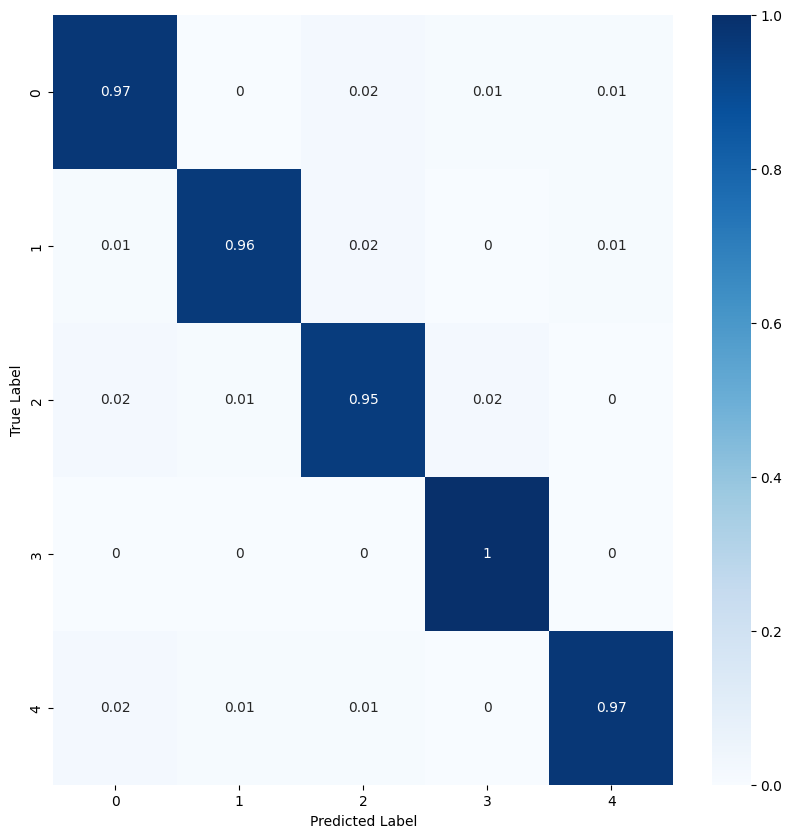

In [ ]:
plot_confusion_matrix(X_test, Y_test, clf)

Evaluation of **Random Forest** Classifier

In [61]:
evaluate_model(X_test, Y_test, clf)

Accuracy: 0.9641

Classification Report:
+-----------+-----------+-----------+-----------+
|           | Precision | Recall    | F1-Score  |
+-----------+-----------+-----------+-----------+
| business  |      0.93 |      0.96 |      0.95 |
+-----------+-----------+-----------+-----------+
| entertainment |      0.98 |      0.95 |      0.96 |
+-----------+-----------+-----------+-----------+
| politics  |      0.95 |      0.95 |      0.95 |
+-----------+-----------+-----------+-----------+
| sport     |      0.97 |      1.00 |      0.99 |
+-----------+-----------+-----------+-----------+
| tech      |      0.98 |      0.95 |      0.97 |
+-----------+-----------+-----------+-----------+


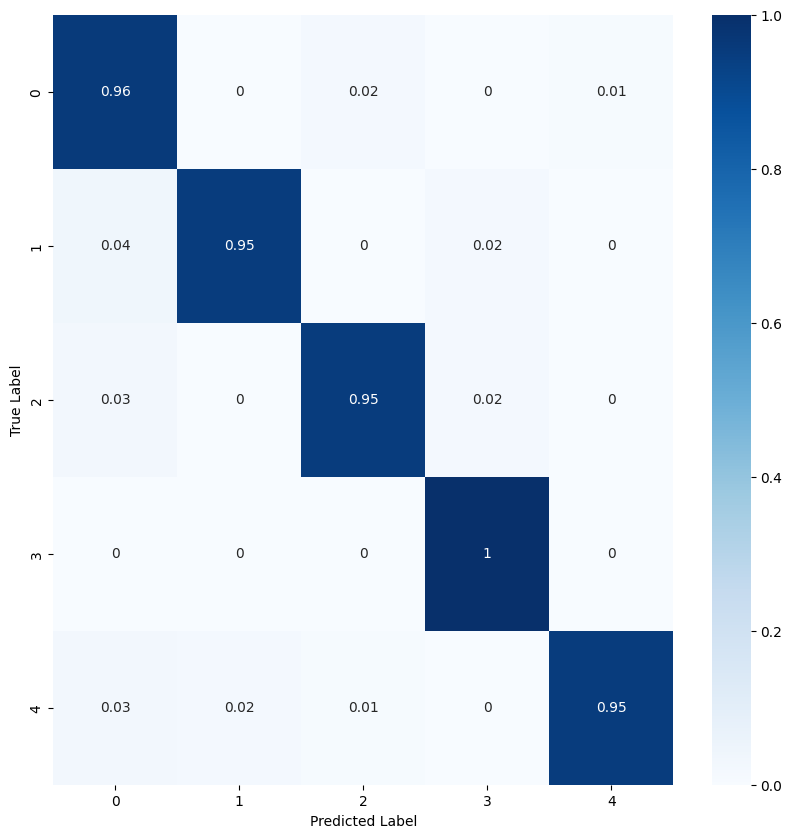

In [63]:
plot_confusion_matrix(X_test, Y_test, clf)

2.Evaluation of **SVM**

In [ ]:
evaluate_model(X_test, Y_test, grid_search_svm)

Accuracy: 0.9671

Classification Report:
+-----------+-----------+-----------+-----------+
|           | Precision | Recall    | F1-Score  |
+-----------+-----------+-----------+-----------+
| business  |      0.96 |      0.96 |      0.96 |
+-----------+-----------+-----------+-----------+
| entertainment |      0.99 |      0.95 |      0.97 |
+-----------+-----------+-----------+-----------+
| politics  |      0.94 |      0.95 |      0.95 |
+-----------+-----------+-----------+-----------+
| sport     |      0.97 |      1.00 |      0.98 |
+-----------+-----------+-----------+-----------+
| tech      |      0.97 |      0.97 |      0.97 |
+-----------+-----------+-----------+-----------+


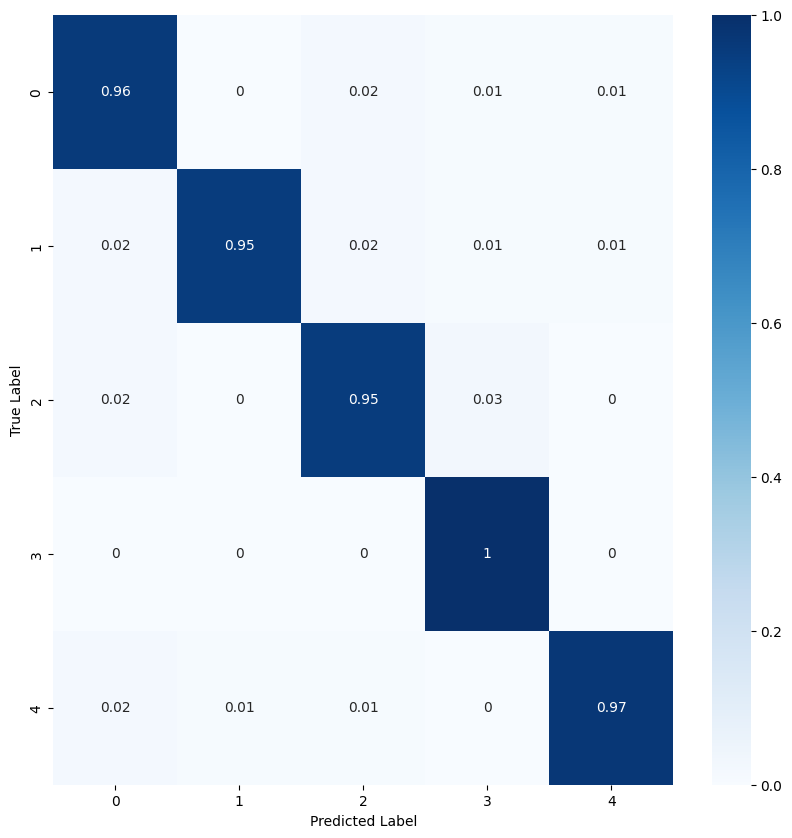

In [ ]:
plot_confusion_matrix(X_test, Y_test, grid_search_svm)

3. Evaluation of **Logistic Regression**

In [ ]:
evaluate_model(X_test, Y_test, grid_search_logistic)

Accuracy: 0.9686

Classification Report:
+-----------+-----------+-----------+-----------+
|           | Precision | Recall    | F1-Score  |
+-----------+-----------+-----------+-----------+
| business  |      0.97 |      0.96 |      0.97 |
+-----------+-----------+-----------+-----------+
| entertainment |      0.98 |      0.95 |      0.96 |
+-----------+-----------+-----------+-----------+
| politics  |      0.95 |      0.95 |      0.95 |
+-----------+-----------+-----------+-----------+
| sport     |      0.97 |      1.00 |      0.99 |
+-----------+-----------+-----------+-----------+
| tech      |      0.97 |      0.97 |      0.97 |
+-----------+-----------+-----------+-----------+


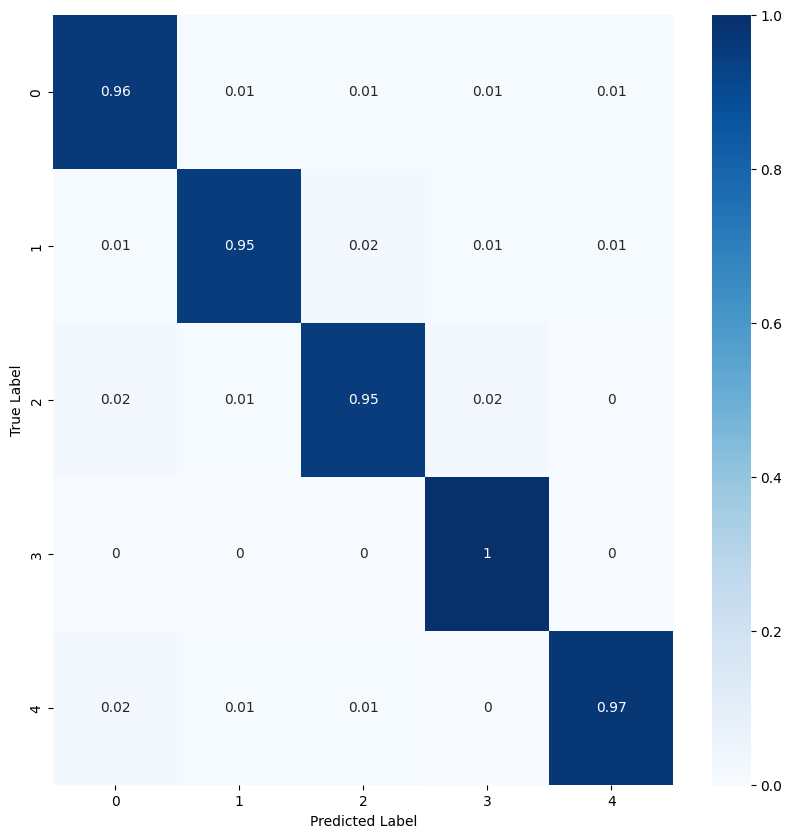

In [ ]:
plot_confusion_matrix(X_test, Y_test, grid_search_logistic)